In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import chain, product
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_curve, auc

In [2]:
fpath = Path('../data/prepared_data.csv')

In [66]:
data = pd.read_csv(fpath, index_col=0).sort_values(by=['customer_id', 'transaction_month']).reset_index(drop=True)

print(data.shape)

data.head(10)

(66370, 4)


,customer_id,mccs,mccs_count,transaction_month
0,0001f322716470bf9bfc1708f06f00fc,"6011,6011,6011,6011,6011,6011,6011",7,2
1,0001f322716470bf9bfc1708f06f00fc,"6011,6011,6011,6011,6011,6011,6011",7,3
2,0001f322716470bf9bfc1708f06f00fc,"5541,6011,6011,6011,6011,6011,6011,6011,6011",9,4
3,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5541,5912,6011,6011,6011,6011,6011",9,5
4,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5411,5411,5499,5541,5541,5999,5999,6...",18,6
5,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5541,5999,6011,6011,6011",7,7
6,0001f322716470bf9bfc1708f06f00fc,"5411,5411,6011,6011,6011,6011,6011",7,8
7,0001f322716470bf9bfc1708f06f00fc,"5211,5411,5541,6011,6011,6011,6011,6011,6011,6...",11,9
8,0007297d86e14bd68bd87b1dbdefe302,"6011,6011,6011,6011,6011,6011",6,2
9,0007297d86e14bd68bd87b1dbdefe302,"6011,6011,6011,6011,6011,6011",6,3


In [67]:
months = sorted(data['transaction_month'].unique().tolist())
months

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [68]:
customers = data['customer_id'].unique().tolist()

len(customers)

9988

Распределение количества месяцев по пользователям.

In [69]:
data['customer_id'].value_counts().value_counts()

8    4362
6    1554
7    1309
5     846
4     616
9     478
3     452
2     264
1     107
Name: customer_id, dtype: int64

В столбце `mccs` в `data` записан список всех категорий товаров, приобретённых в данном месяце, разделённых запятой.

In [70]:
def deserialize_int_list(list_string: str) -> list:
    return [int(item) for item in list_string.split(',')]

In [71]:
data['mccs'] = data['mccs'].apply(deserialize_int_list)
data.head()

,customer_id,mccs,mccs_count,transaction_month
0,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,2
1,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,3
2,0001f322716470bf9bfc1708f06f00fc,"[5541, 6011, 6011, 6011, 6011, 6011, 6011, 601...",9,4
3,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5541, 5912, 6011, 6011, 6011, 601...",9,5
4,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5411, 5411, 5499, 5541, 5541, 599...",18,6


In [72]:
mccs = list(set(chain.from_iterable(data['mccs'])))
n_mccs = len(mccs)
mcc2id = dict(zip(mccs, range(n_mccs)))

n_mccs

243

Получаем векторы корзин с помощью Bag of words.

In [73]:
def get_bow_vector(mccs: list) -> np.ndarray:
    vector = np.zeros(n_mccs)
    
    for mcc in mccs:
        mid = mcc2id[mcc]
        vector[mid] += 1
        
    return vector

In [74]:
data['vector'] = data['mccs'].apply(get_bow_vector)
data.head()

,customer_id,mccs,mccs_count,transaction_month,vector
0,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0001f322716470bf9bfc1708f06f00fc,"[5541, 6011, 6011, 6011, 6011, 6011, 6011, 601...",9,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5541, 5912, 6011, 6011, 6011, 601...",9,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5411, 5411, 5499, 5541, 5541, 599...",18,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [75]:
def get_data(months: list):
    x = []
    y = []
    
    for cid in tqdm(customers):
        cdata = data[data['customer_id'] == cid]
        cmonths = set(cdata['transaction_month'].tolist())
        
        if all(month in cmonths for month in months):
            vectors = cdata.loc[cdata['transaction_month'].isin(months), 'vector'].values.tolist()
            x_ = np.array(vectors[:-1])
            y_ = vectors[-1]
                    
            x.append(x_)
            y.append(y_)
        
    return x, y

In [86]:
n_months = 5

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(months) - n_months + 1):
    months_ = months[i:i + n_months]
    
    print(f'months: {months_}')
    
    x, y = get_data(months=months_)
    
    if months_[-1] == 9:
        x_test.extend(x)
        y_test.extend(y)
    
    else:
        x_train.extend(x)
        y_train.extend(y)
        
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

months: [1, 2, 3, 4, 5]



months: [2, 3, 4, 5, 6]



months: [3, 4, 5, 6, 7]



months: [4, 5, 6, 7, 8]



months: [5, 6, 7, 8, 9]



(18772, 4, 243) (18772, 243)
(7010, 4, 243) (7010, 243)


In [87]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train[0].shape),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_mccs, activation='sigmoid'),
])

In [88]:
model.compile(
    optimizer='adam',
    loss='mse',
)

In [89]:
model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_test, y_test),
)

Train on 18772 samples, validate on 7010 samples
Epoch 1/10
18772/18772 [==============================] - 7s 394us/sample - loss: 0.9543 - val_loss: 0.7864
Epoch 2/10
18772/18772 [==============================] - 6s 334us/sample - loss: 0.9435 - val_loss: 0.7849
Epoch 3/10
18772/18772 [==============================] - 6s 336us/sample - loss: 0.9422 - val_loss: 0.7844
Epoch 4/10
18772/18772 [==============================] - 6s 342us/sample - loss: 0.9414 - val_loss: 0.7843
Epoch 5/10
18772/18772 [==============================] - 6s 335us/sample - loss: 0.9408 - val_loss: 0.7845
Epoch 6/10
18772/18772 [==============================] - 6s 338us/sample - loss: 0.9403 - val_loss: 0.7839
Epoch 7/10
18772/18772 [==============================] - 6s 336us/sample - loss: 0.9399 - val_loss: 0.7839
Epoch 8/10
18772/18772 [==============================] - 6s 337us/sample - loss: 0.9394 - val_loss: 0.7839
Epoch 9/10
18772/18772 [==============================] - 6s 336us/sample - loss: 0.939

In [90]:
y_pred = model.predict(x_test)
y_pred.shape

(7010, 243)

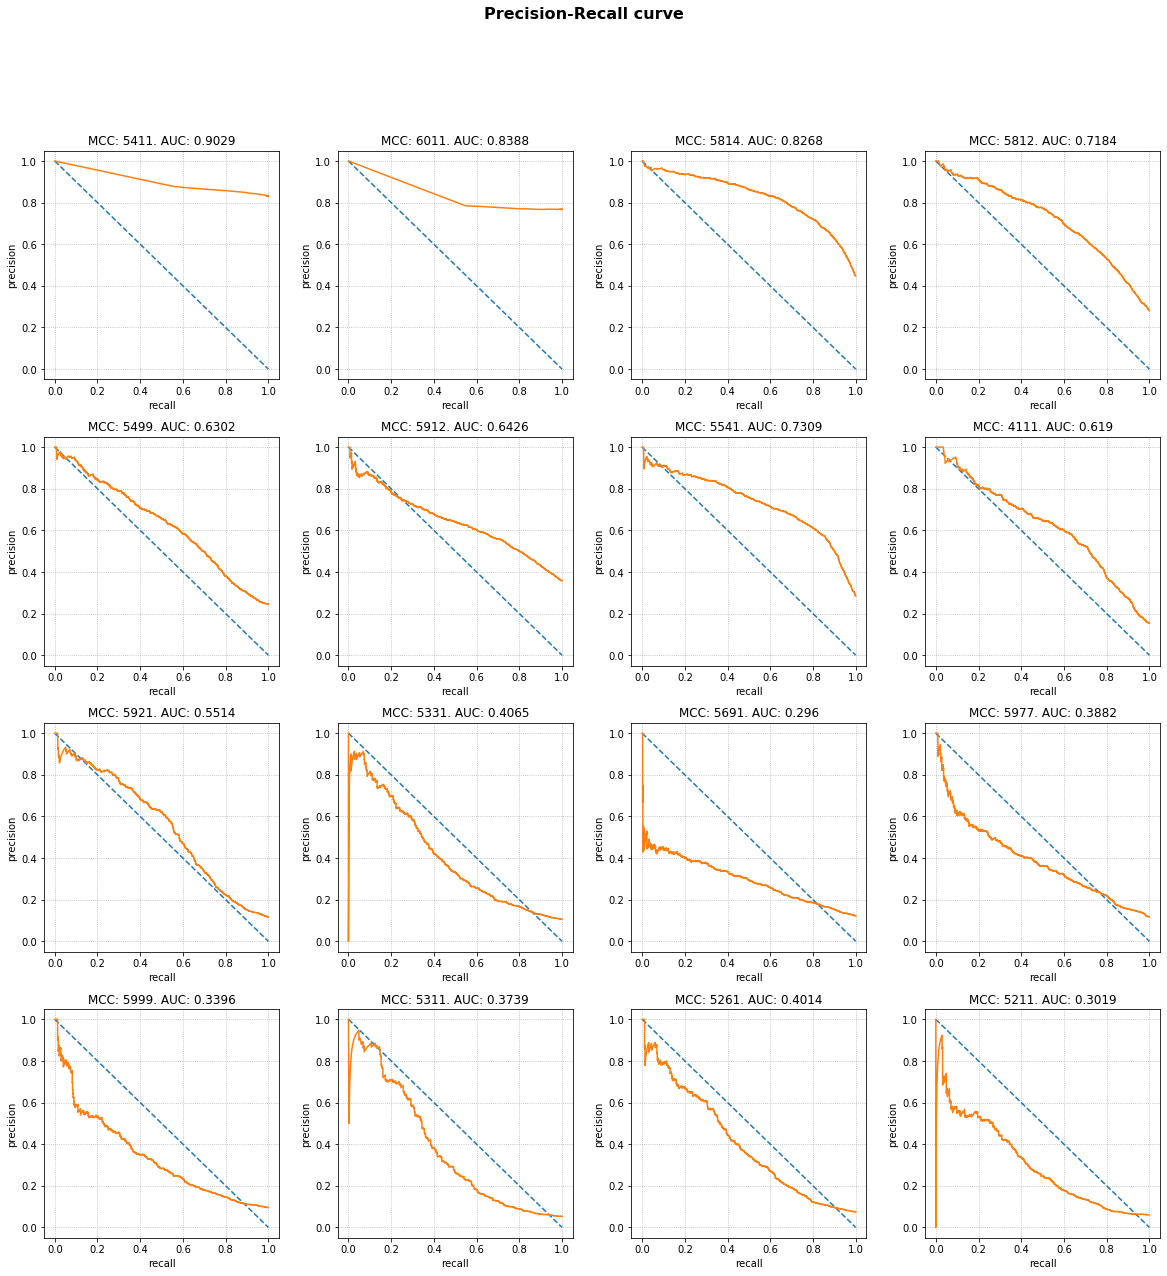

In [91]:
fig, axes = plt.subplots(nrows=4, ncols=4)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
fig.set_size_inches(20, 20)
axes = axes.flatten()

fig.suptitle('Precision-Recall curve', fontsize=16, fontweight='bold')

for mid, ax in zip(y_test.sum(axis=0).argsort()[::-1], axes):
    mcc = mccs[mid]

    x, y, _ = precision_recall_curve(y_test[:, mid] > 0, y_pred[:, mid])
    score = auc(y, x)

    ax.plot([0, 1], [1, 0], ls='dashed')
    ax.plot(y, x)

    ax.set_title(f'MCC: {mcc}. AUC: {round(score, 4)}')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.grid(linestyle='dotted')

In [92]:
def get_top5_mccs(probas: np.ndarray) -> set:
    top5_ids = probas.argsort()[-5:]
    top5_ids = [id_ for id_ in top5_ids if probas[id_] > 0]
    top5_mccs = {mccs[id_] for id_ in top5_ids}
    
    return top5_mccs

In [93]:
def jaccard(set1: set, set2: set) -> float:
    return len(set.intersection(set1, set2)) / len(set.union(set1, set2))

In [96]:
y_test_top5 = [get_top5_mccs(vector) for vector in y_test]
y_pred_top5 = [get_top5_mccs(vector) for vector in y_pred]

Text(0, 0.5, 'probability')

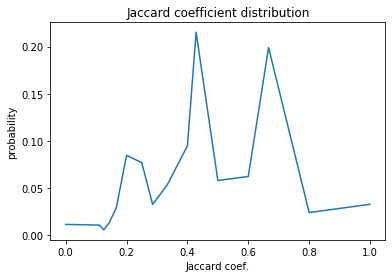

In [100]:
jac = [jaccard(s1, s2) for s1, s2 in zip(y_test_top5, y_pred_top5)]
jac = pd.Series(jac).value_counts().sort_index()
jac = jac / jac.sum()

plt.plot(jac)
plt.title('Jaccard coefficient distribution')
plt.xlabel('Jaccard coef.')
plt.ylabel('probability')